In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import os
style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def load_layer(patient, sample, metadata):
    """
    Return Layer object of Patient, Sample
    """
    layer = "../data/P" + str(patient) + "/layer" + str(sample) + ".tsv"
    coor_path = "../data/P" + str(patient) + "/layer" + str(sample) + "_coordinates.tsv"
    adata = anndata.read_csv(layer, delimiter="\t")

    # Data pre-processing
    coor = pd.read_csv(coor_path, sep="\t").iloc[:,:2]
    coor_index = []
    for pair in coor.values:
        coor_index.append('x'.join(str(e) for e in pair))
    coor.index = coor_index
    # The metadata, coordinates, and gene expression might have missing cells between them
    idx = paste.intersect(coor_index, adata.obs.index)
    
    df = metadata[metadata['patient'] == patient]
    df = df[df['sample'] == sample]
    
    meta_idx = []
    for i in df.index:
        meta_idx.append(i.split('_')[1])
    idx = paste.intersect(idx, meta_idx)
    
    adata = adata[idx, :]
    adata.obsm['spatial'] = np.array(coor.loc[idx, :])
    metadata_idx = ['P' + str(patient) + '_' + i + '_' + str(sample) for i in idx]
    adata.obs['original_clusters'] = list(metadata.loc[metadata_idx, 'SCT_snn_res.0.8'])
    return adata

In [3]:
metadata_path =  "../data/ST_all_metadata.txt"
metadata = pd.read_csv(metadata_path, sep="\t", index_col=0)

In [4]:
adata_2_1 = load_layer(2, 1, metadata)
adata_2_2 = load_layer(2, 2, metadata)
adata_2_3 = load_layer(2, 3, metadata)

patient_2 = [adata_2_1, adata_2_2, adata_2_3]

for adata in patient_2:
    sc.pp.filter_genes(adata, min_cells = 15, inplace = True)
    sc.pp.filter_cells(adata, min_genes= 100, inplace= True)

# Run Analysis

In [5]:
import networkx as nx
from scipy.spatial import distance_matrix

def create_graph(adata, degree = 4):
        """
        Converts spatial coordinates into graph using networkx library.
        
        param: adata - ST Slice 
        param: degree - number of edges per vertex

        return: 1) G - networkx graph
                2) node_dict - dictionary mapping nodes to spots
        """
        D = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
        # Get column indexes of the degree+1 lowest values per row
        idx = np.argsort(D, 1)[:, 0:degree+1]
        # Remove first column since it results in self loops
        idx = idx[:, 1:]

        G = nx.Graph()
        for r in range(len(idx)):
            for c in idx[r]:
                G.add_edge(r, c)

        node_dict = dict(zip(range(adata.shape[0]), adata.obs.index))
        return G, node_dict
    
def generate_graph_from_labels(adata, labels_dict):
    """
    Creates and returns the graph and dictionary {node: cluster_label} for specified layer
    """
    
    g, node_to_spot = create_graph(adata)
    spot_to_cluster = labels_dict

    # remove any nodes that are not mapped to a cluster
    removed_nodes = []
    for node in node_to_spot.keys():
        if (node_to_spot[node] not in spot_to_cluster.keys()):
            removed_nodes.append(node)

    for node in removed_nodes:
        del node_to_spot[node]
        g.remove_node(node)
        
    labels = dict(zip(g.nodes(), [spot_to_cluster[node_to_spot[node]] for node in g.nodes()]))
    return g, labels

def spatial_coherence_score(graph, labels):
    g, l = graph, labels
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
        
    return (true_entropy - np.mean(entropies))/np.std(entropies)

def spatial_entropy(g, labels):
    """
    Calculates spatial entropy of graph  
    """
    # construct contiguity matrix C which counts pairs of cluster edges
    cluster_names = np.unique(list(labels.values()))
    C = pd.DataFrame(0,index=cluster_names, columns=cluster_names)

    for e in g.edges():
        C[labels[e[0]]][labels[e[1]]] += 1

    # calculate entropy from C
    C_sum = C.values.sum()
    H = 0
    for i in range(len(cluster_names)):
        for j in range(i, len(cluster_names)):
            if (i == j):
                z = C[cluster_names[i]][cluster_names[j]]
            else:
                z = C[cluster_names[i]][cluster_names[j]] + C[cluster_names[j]][cluster_names[i]]
            if z != 0:
                H += -(z/C_sum)*math.log(z/C_sum)
    return H

In [6]:
def cluster_dict(metadata, patient, sample):
    """
    Returns dictionary of {spot: cluster label}
    """
    df = metadata[metadata['patient'] == patient]
    df = df[df['sample'] == sample]
    x = df['ads_x']
    y = df['ads_y']
    spot_index = []
    for (spot1, spot2) in zip(x, y):
        spot_index.append(str(round(spot1)) + 'x' + str(round(spot2)))
    return dict(zip(spot_index, df['SCT_snn_res.0.8']))

## Using ST Metadata

### Manual Input Example

In [39]:
df = pd.read_csv('./SCC-clusters-patient2-down-0-5.csv')

In [40]:
new_df = df[df['which_slice'] == 1]
c = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
g, l = generate_graph_from_labels(adata_2_1, c)
spatial_coherence_score(g, l)

-27.150697754163488

In [41]:
new_df = df[df['which_slice'] == 2]
c = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
g, l = generate_graph_from_labels(adata_2_2, c)
spatial_coherence_score(g, l)

-25.07390536128164

In [42]:
new_df = df[df['which_slice'] == 3]
c = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
g, l = generate_graph_from_labels(adata_2_3, c)
spatial_coherence_score(g, l)

-28.518282337397665

### Automated Example

In [10]:
filenames = os.listdir('./scc-p2-downsampled/')
spatial_scores = []
for f in filenames:
    df = pd.read_csv('./scc-p2-downsampled/' + f)
    s = []
    for i in [1, 2, 3]:
        new_df = df[df['which_slice'] == i]
        c = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
        g, l = generate_graph_from_labels(patient_2[i- 1], c)
        s.append(spatial_coherence_score(g, l))
    spatial_scores.append(s)

In [14]:
results = pd.DataFrame(spatial_scores, index = filenames, columns = ['Slice A', 'Slice B', 'Slice C']).sort_index()

In [15]:
results.to_csv('./results/scc-p2-downsampled/spatial_scores.csv')

### Plot

In [2]:
spatial_df = pd.read_csv('./results/scc-p2-downsampled/spatial_scores.csv', index_col= 0)

In [10]:
txt = "SCC-clusters-patient2-down-"
idxs = []
for i in [0.2, 0.4, 0.6, 0.8, 0.9]:
    idxs.append(txt + str(i) + ".csv")
spatial_df = spatial_df.drop(idxs)
    

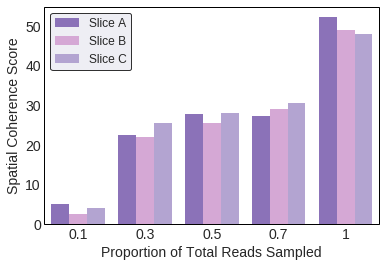

In [12]:
plt.figure(figsize= (6, 4))

colors = [ "#8766c4", "#dda0dd", "#b19cd9"]
bar_label = spatial_df.shape[0]*['Slice A', 'Slice B', 'Slice C']
labels = []
for idx in spatial_df.index[:-1]:
    n = idx.split('-')[-1:]
    n = n[0].replace('.csv', '')
    for i in range(spatial_df.shape[1]):
        labels.append(n)
labels += spatial_df.shape[1]*['1']
scores = np.abs(spatial_df.values.flatten())
ax2 = sns.barplot(x=labels, y = scores, hue=bar_label, palette=sns.color_palette(colors))
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')  
ax2.set_ylabel("Spatial Coherence Score", fontsize = 14)
ax2.set_xlabel("Proportion of Total Reads Sampled", fontsize = 14)
plt.legend(frameon=True, edgecolor='black', fontsize = 12)
# plt.savefig('cSCC_spatial_entropy.pdf', dpi = 300, bbox_inches = "tight")

# Generate Spatial vs Accuracy Plot

In [19]:
def ot_analysis(sliceA, sliceB, alpha, spot_to_cluster_A, spot_to_cluster_B):
    """
    Calculates optimal transport alignment and returns % of spots preserved among clusters.
    """
    # Calculate optimal transport aligment
    G = paste.pairwise_align(sliceA, sliceB, alpha)
    
    spotsA, spotsB = np.nonzero(G)

    s = 0
    for i in range(len(spotsA)):
        # get the clusters corresponding to each spot
        a = spot_to_cluster_A[sliceA.obs_names[spotsA[i]]]
        b = spot_to_cluster_B[sliceB.obs_names[spotsB[i]]]
        if a == b:
            s += G[spotsA[i]][spotsB[i]]
    return s



In [ ]:
def getCluster(index, patient, sample, layer, metadata):
    """
    Returns cluster label of a specific spot in the layer. If cluster label does not exist, return -1.
    """
    spot_index = 'P' + str(patient) + '_' + layer.gene_exp.index[index] + '_' + str(sample)
    if spot_index in metadata.index:
        return metadata.loc[spot_index]['SCT_snn_res.0.8']
    else:
        return -1

In [ ]:
filenames = os.listdir('./scc-p2-downsampled/')
accuracy_scores = []
for f in filenames:
    a = []
    df = pd.read_csv('./scc-p2-downsampled/' + f)
    new_df = df[df['which_slice'] == 1]
    c_1 = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
    new_df = df[df['which_slice'] == 2]
    c_2 = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
    new_df = df[df['which_slice'] == 3]
    c_3 = dict(zip([x.split('_')[0] for x in new_df['spot_ids']], new_df['cluster_labels']))
    a.append(ot_analysis(adata_2_1, adata_2_2, 0.1, c_1, c_2))
    a.append(ot_analysis(adata_2_2, adata_2_3, 0.1, c_2, c_3))
    accuracy_scores.append(a)

In [ ]:
results = pd.DataFrame(accuracy_scores, index = filenames, columns = ['Slice A, Slice B', 'Slice B, Slice C']).sort_index()

In [ ]:
results.to_csv('./results/scc-p2-downsampled/accuracy_scores.csv')

In [39]:
c_1 = dict(adata_2_1.obs['original_clusters'])
c_2 = dict(adata_2_2.obs['original_clusters'])
c_3 = dict(adata_2_3.obs['original_clusters'])

### Plot

In [13]:
accuracy_df = pd.read_csv('./results/scc-p2-downsampled/accuracy_scores.csv', index_col= 0).sort_index(ascending = False)

In [16]:
txt = "SCC-clusters-patient2-down-"
idxs = []
for i in [0.2, 0.4, 0.6, 0.8, 0.9]:
    idxs.append(txt + str(i) + ".csv")
accuracy_df = accuracy_df.drop(idxs)

/home/max/Programs/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

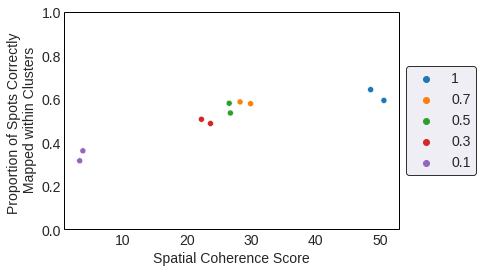

In [19]:
plt.figure(figsize= (6, 4))

z = []
for i in range(spatial_df.shape[0]):
    for j in range(spatial_df.shape[1] - 1):
        z.append((spatial_df.iloc[i][j] + spatial_df.iloc[i][j+1])/2)

p = accuracy_df.values.flatten()

labels = []
labels += accuracy_df.shape[1]*['1']
for idx in accuracy_df.index[1:]:
    n = idx.split('-')[-1:]
    n = n[0].replace('.csv', '')
    for i in range(accuracy_df.shape[1]):
        labels.append(n)


palette = sns.color_palette(n_colors= accuracy_df.shape[0])

ax = sns.scatterplot(np.flip(np.abs(z)), p, hue = labels, palette=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, edgecolor='black', fontsize= 14)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_ylim(0, 1)
ax.set_xlabel("Spatial Coherence Score", fontsize = 14)
ax.set_ylabel("Proportion of Spots Correctly \n Mapped within Clusters", fontsize = 14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)

# plt.savefig('cSCC_downsample_spatial_entropy_vs_accuracy.pdf', dpi = 300, bbox_inches = "tight")